# 1. Import một số thư viện cần thiết


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf


# Đọc dữ liệu từ tệp CSV
df = pd.read_csv('MSN.csv')

# Chọn cột Price và loại bỏ các giá trị thiếu

df = df[['Price']].dropna().reset_index(drop=True)

#2 Phân chia dữ liệu thành tập huấn luyện, kiểm tra và validation theo tỉ lệ 7:2:1

In [50]:

train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size + test_size]
val_data = df[train_size + test_size:]

# Tiến hành training mô hình AR
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])


#3. tìm số lượng lag phù hợp cho mô hình

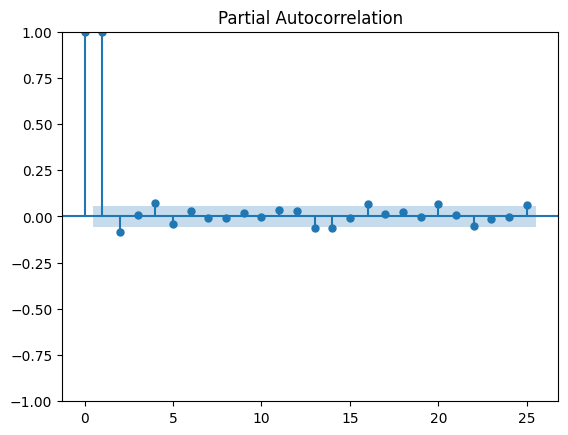

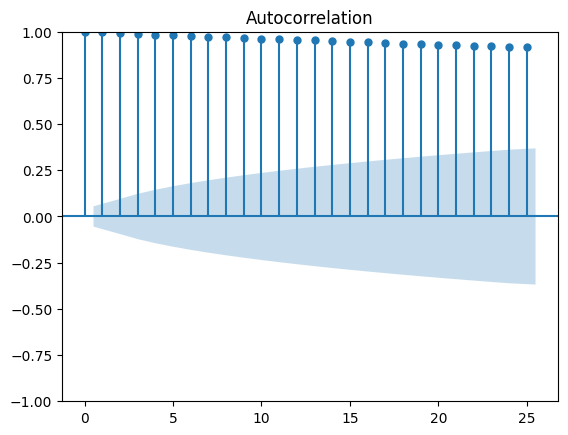

In [51]:
pacf= plot_pacf(df['Price'],lags=25)
acf= plot_acf(df['Price'],lags=25)

#4 Dự đoán giá trong 30 ngày tới

In [52]:
model = AutoReg(y_train, lags=1)   # Lấy lag là 1, tức là mô hình AR(1)
model_fit = model.fit()

# Dự đoán trên tập kiểm tra
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Dự đoán trên tập validation
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val = model_fit.predict(start=len(train_data) + len(test_data), end=len(train_data) + len(test_data) + len(val_data) - 1, dynamic=False)

# Tạo index cho 30 ngày tiếp theo
last_index = df.index[-1]
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

# Dự đoán giá cho 30 ngày tiếp theo
y_next_30_days = model_fit.predict(start=len(df), end=len(df) + 29, dynamic=False)

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[102723.53376266 102708.13165739 102692.76373459 102677.42991839
 102662.13013308 102646.86430315 102631.63235324 102616.43420816
 102601.26979287 102586.13903254 102571.04185245 102555.97817809
 102540.9479351  102525.95104927 102510.98744659 102496.05705318
 102481.15979534 102466.29559953 102451.46439238 102436.66610067
 102421.90065136 102407.16797155 102392.46798851 102377.80062969
 102363.16582268 102348.56349523 102333.99357527 102319.45599086
 102304.95067025 102290.47754183]


#5 Đánh giá độ chính xác thuật toán

In [53]:
# Tính toán các chỉ số đánh giá RMSE, MSE, MAPE

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_mape = mean_absolute_percentage_error(y_val, y_pred_val)*100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)
print('Validation RMSE:', val_rmse)
print('Validation MAE:', val_mae)
print('Validation MAPE:', val_mape)

Testing RMSE: 24830.248794280327
Testing MAE: 23238.31834387726
Testing MAPE: 28.81215088656633
Validation RMSE: 36207.9498805681
Validation MAE: 35754.256441653124
Validation MAPE: 53.52584505240529


#6. Vẽ biểu đồ

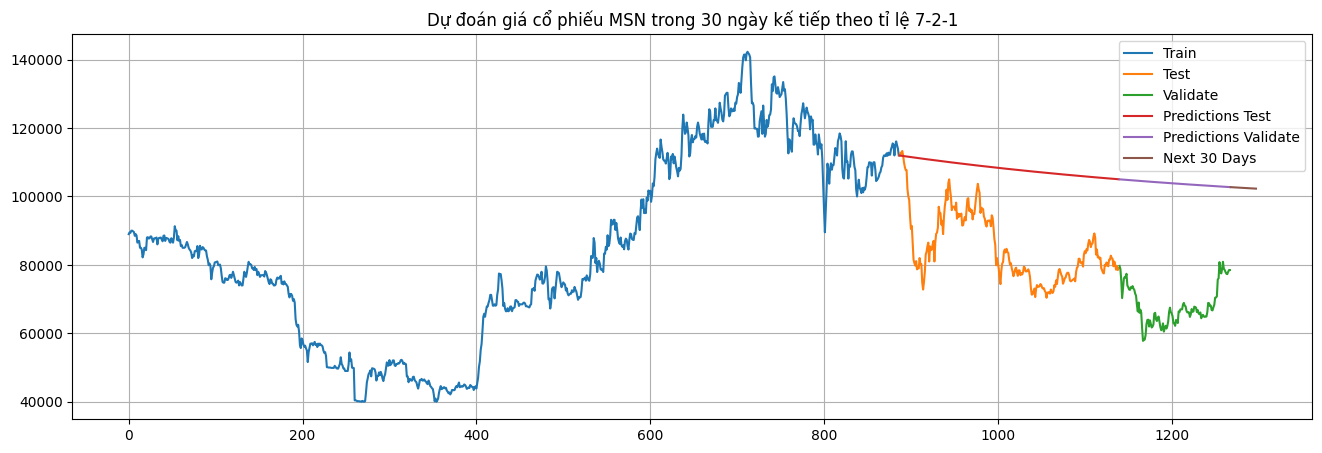

In [54]:
# Vẽ biểu đồ
plt.figure(figsize=(16,5))
plt.title("Dự đoán giá cổ phiếu MSN trong 30 ngày kế tiếp theo tỉ lệ 7-2-1")
plt.grid(True)
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(x_next_30_days, y_next_30_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions Test', 'Predictions Validate', 'Next 30 Days'])
plt.show()

#7. Chia tập dữ liệu để train-test-validate theo tỉ lệ 6:3:1



In [55]:
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size + test_size]
val_data = df[train_size + test_size:]

# Tiến hành training mô hình AR
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

#8. Tìm số lượng lag phù hợp

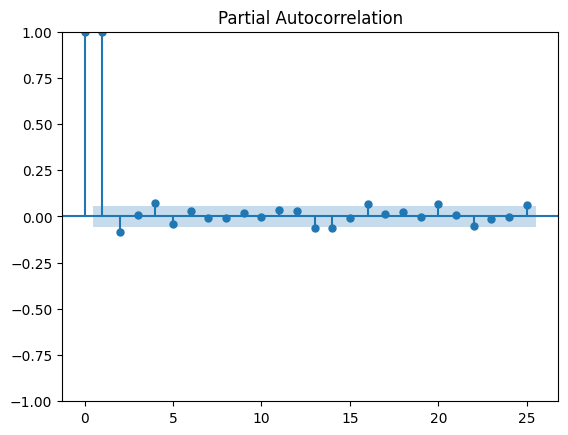

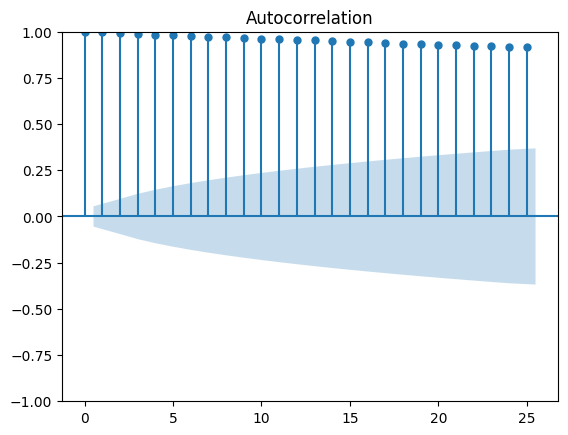

In [56]:
pacf= plot_pacf(df['Price'],lags=25)
acf= plot_acf(df['Price'],lags=25)

#9.Dự đoán trong 30 ngày tới


In [57]:
model = AutoReg(y_train, lags=1)   # Lấy lag là 1, tức là mô hình AR(1)
model_fit = model.fit()

# Dự đoán trên tập kiểm tra
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Dự đoán trên tập validation
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val = model_fit.predict(start=len(train_data) + len(test_data), end=len(train_data) + len(test_data) + len(val_data) - 1, dynamic=False)

# Tạo index cho 30 ngày tiếp theo
last_index = df.index[-1]
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

# Dự đoán giá cho 30 ngày tiếp theo
y_next_30_days = model_fit.predict(start=len(df), end=len(df) + 29, dynamic=False)

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[106022.7801931  106014.17178139 106005.57620318 105996.99343934
 105988.42347077 105979.86627838 105971.32184313 105962.79014601
 105954.27116802 105945.7648902  105937.27129362 105928.79035937
 105920.32206857 105911.86640238 105903.42334198 105894.99286857
 105886.57496339 105878.16960769 105869.77678278 105861.39646997
 105853.02865061 105844.67330607 105836.33041776 105827.9999671
 105819.68193555 105811.3763046  105803.08305577 105794.80217058
 105786.53363062 105778.27741747]


#10. Đánh giá độ chính xác thuật toán

In [58]:
# Tính toán các chỉ số đánh giá RMSE, MSE, MAPE

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_mape = mean_absolute_percentage_error(y_val, y_pred_val)*100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)
print('Validation RMSE:', val_rmse)
print('Validation MAE:', val_mae)
print('Validation MAPE:', val_mape)

Testing RMSE: 21220.111721764548
Testing MAE: 17696.96853255012
Testing MAPE: 21.34595623162063
Validation RMSE: 38960.715348055084
Validation MAE: 38550.089949771165
Validation MAPE: 57.65439955299665


#11. Vẽ biểu đồ

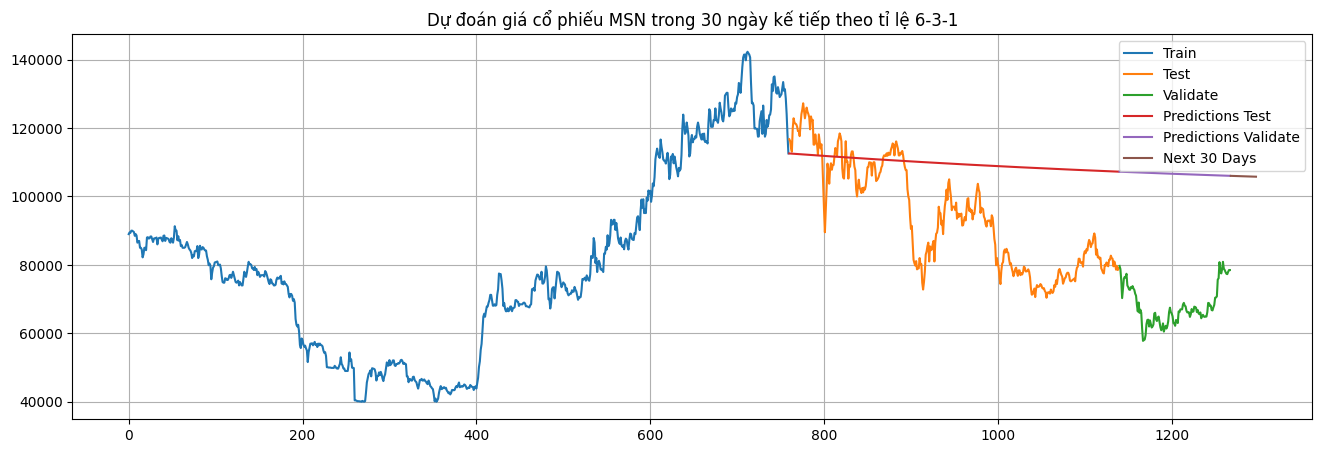

In [59]:
# Vẽ biểu đồ
plt.figure(figsize=(16,5))
plt.title("Dự đoán giá cổ phiếu MSN trong 30 ngày kế tiếp theo tỉ lệ 6-3-1")
plt.grid(True)
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(x_next_30_days, y_next_30_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions Test', 'Predictions Validate', 'Next 30 Days'])
plt.show()

#12. Chia tập dữ liệu để train-test-validate theo tỉ lệ 5:3:2

In [60]:
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size + test_size]
val_data = df[train_size + test_size:]

# Tiến hành training mô hình AR
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

#13. Tìm số lượng lag phù hợp

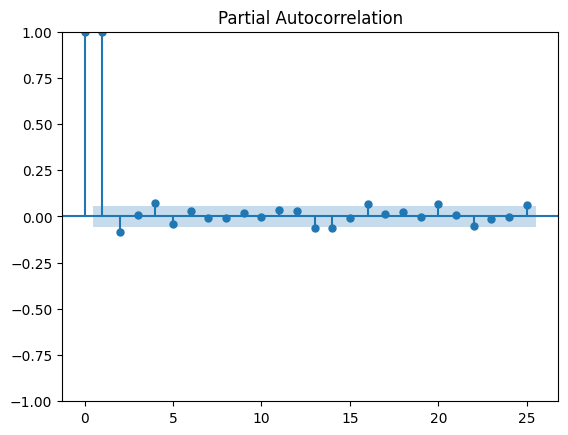

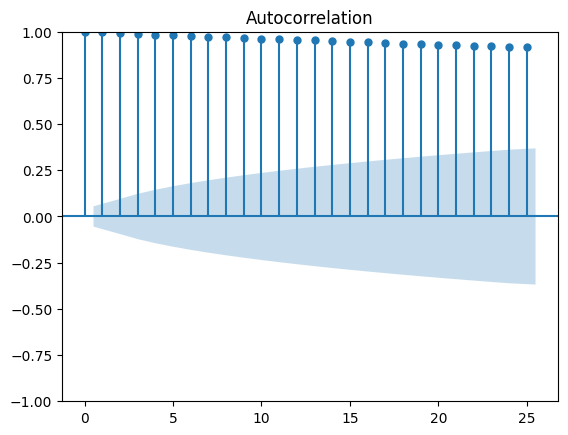

In [61]:
pacf= plot_pacf(df['Price'],lags=25)
acf= plot_acf(df['Price'],lags=25)

#14. Dự đoán 30 ngày tới

In [62]:
model = AutoReg(y_train, lags=1)   # Lấy lag là 1, tức là mô hình AR(1)
model_fit = model.fit()

# Dự đoán trên tập kiểm tra
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Dự đoán trên tập validation
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val = model_fit.predict(start=len(train_data) + len(test_data), end=len(train_data) + len(test_data) + len(val_data) - 1, dynamic=False)

# Tạo index cho 30 ngày tiếp theo
last_index = df.index[-1]
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

# Dự đoán giá cho 30 ngày tiếp theo
y_next_30_days = model_fit.predict(start=len(df), end=len(df) + 29, dynamic=False)

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[103894.79534091 103889.86221589 103884.93432557 103880.01166439
 103875.09422681 103870.18200729 103865.27500028 103860.37320025
 103855.47660169 103850.58519907 103845.69898687 103840.8179596
 103835.94211174 103831.07143781 103826.2059323  103821.34558975
 103816.49040466 103811.64037157 103806.79548501 103801.95573951
 103797.12112963 103792.29164991 103787.46729491 103782.64805919
 103777.83393732 103773.02492387 103768.22101342 103763.42220056
 103758.62847988 103753.83984597]


#15. Đánh giá độ chính xác thuật toán

In [63]:
# Tính toán các chỉ số đánh giá RMSE, MSE, MAPE

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_mape = mean_absolute_percentage_error(y_val, y_pred_val)*100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)
print('Validation RMSE:', val_rmse)
print('Validation MAE:', val_mae)
print('Validation MAPE:', val_mape)

Testing RMSE: 15224.883677053072
Testing MAE: 12863.631510616835
Testing MAPE: 12.123342220473672
Validation RMSE: 32281.094428467153
Validation MAE: 31549.788664192783
Validation MAPE: 44.53346833289485


#16. Vẽ biểu đồ

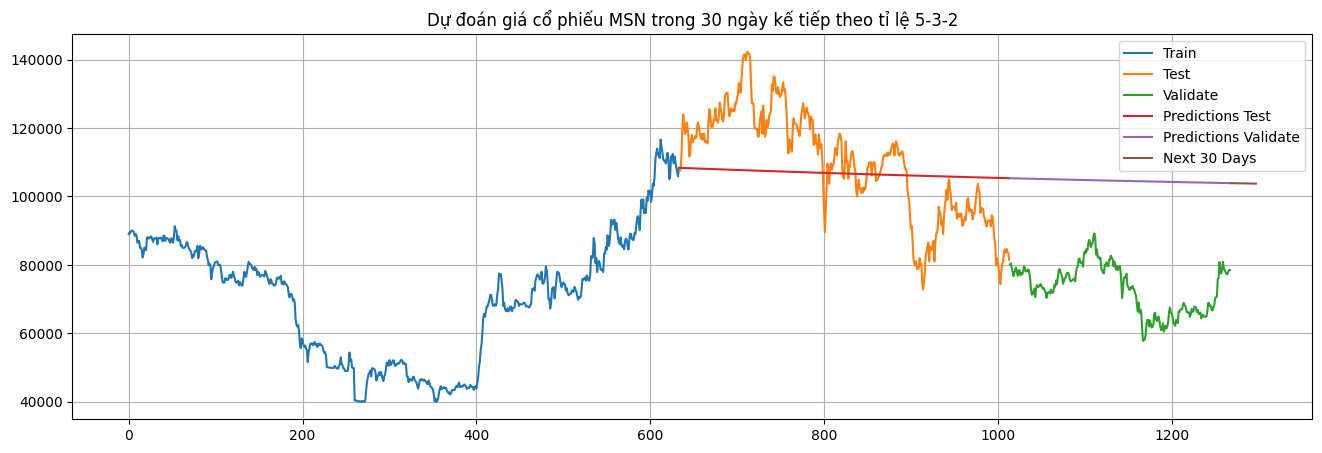

In [65]:
# Vẽ biểu đồ
plt.figure(figsize=(16,5))
plt.title("Dự đoán giá cổ phiếu MSN trong 30 ngày kế tiếp theo tỉ lệ 5-3-2")
plt.grid(True)
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(x_next_30_days, y_next_30_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions Test', 'Predictions Validate', 'Next 30 Days'])
plt.show()